In [5]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.5 MB/s eta 0:00:00


### 1. IMPORTING REQUIRED LIBRARIES

In [6]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import re #(regular expression - a library useful for searching word in a paragraph)
import nltk
from nltk.corpus import stopwords # stopword- words that doesn't add much value of the paragraph , like -'the' ,'with' ,'i',etc.
from nltk.stem import WordNetLemmatizer # returns the root of a word by removing its prefix and suffix
nltk.download('punkt_tab')
from sklearn.feature_extraction.text import TfidfVectorizer # to convert text into feature vector (i.e numbers)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### 2. IMPORTING STOPWORDS

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [8]:
# printing the stopwords of English language
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### 3. DATASET LOADING

In [9]:
news_dataset = pd.read_csv('/content/train.csv')

### 4. DATA PREPROCESSING

In [10]:
# size of dataset
news_dataset.shape

(6335, 4)

In [11]:
# printing the first 5 rows of the dataframe
news_dataset.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
# checking the null values
news_dataset.isnull().sum()

In [12]:
# replacing the null values with empty string
news_dataset = news_dataset.fillna('')

### 5. EXPLORING UNIQUE VALUES

<Axes: xlabel='label', ylabel='count'>

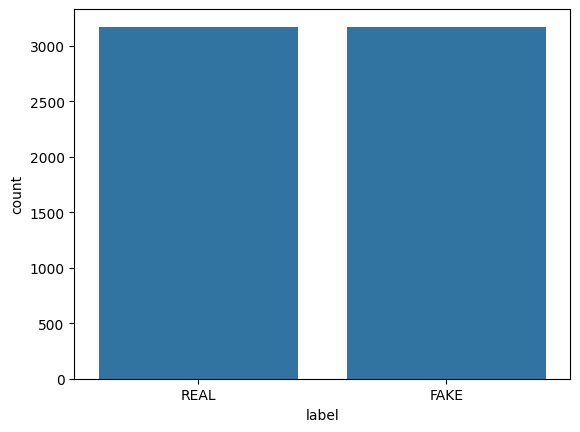

In [13]:
sns.countplot(data=news_dataset,
              x='label',
              order=news_dataset['label'].value_counts().index)

### 6. Making Label REAL=1 and Label FAKE=0

In [14]:
news_dataset.label[news_dataset.label == 'REAL'] = 1
news_dataset.label[news_dataset.label == 'FAKE'] = 0

<ipython-input-14-2505811d5d26>:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  news_dataset.label[news_dataset.label == 'REAL'] = 1
<ipython-input-14-2505811d5d26>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

### 7. Merging the TITLE and AUTHOR column into a single Column BODY

In [15]:
news_dataset['body']=news_dataset['text']+' '+news_dataset['title']
print(news_dataset['body'])

0       Daniel Greenfield, a Shillman Journalism Fello...
1       Google Pinterest Digg Linkedin Reddit Stumbleu...
2       U.S. Secretary of State John F. Kerry said Mon...
3       — Kaydee King (@KaydeeKing) November 9, 2016 T...
4       It's primary day in New York and front-runners...
                              ...                        
6330    The State Department told the Republican Natio...
6331    The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...
6332     Anti-Trump Protesters Are Tools of the Oligar...
6333    ADDIS ABABA, Ethiopia —President Obama convene...
6334    Jeb Bush Is Suddenly Attacking Trump. Here's W...
Name: body, Length: 6335, dtype: object


### 8. TEXT CLEANING

In [16]:
lemmatizer = WordNetLemmatizer()
stpwrds = list(stopwords.words('english'))

In [17]:
for x in range(len(news_dataset)) :
    corpus = []
    review = news_dataset['body'][x]
    review = re.sub(r'https?://\S+|www\.\S+', '', review)  # Remove URLs
    review = re.sub(r'\W', ' ', review)  # Remove special characters
    review = re.sub(r'\n', ' ', review)  # Replace newline characters with a space
    review = re.sub(r'\w*\d\w*', '', review)  # Remove words containing digits
    review = review.lower()  # Convert to lowercase
    review = nltk.word_tokenize(review)  # Tokenize
    for y in review :
        if y not in stpwrds :
            corpus.append(lemmatizer.lemmatize(y))
    review = ' '.join(corpus)
    news_dataset['body'][x] = review

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  news_dataset['body'][x] = review
<ipython-input-17-36200f0d41a0>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_dataset['body'][x] = review
<ipython-input-17-36200f0d41a0>:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are 

In [18]:
# Seperating the data and label
X =news_dataset['body'].values
Y =news_dataset['label'].astype('int').values


In [19]:
print(X)
print(Y)


['daniel greenfield shillman journalism fellow freedom center new york writer focusing radical islam final stretch election hillary rodham clinton gone war fbi word unprecedented thrown around often election ought retired still unprecedented nominee major political party go war fbi exactly hillary people done coma patient waking watching hour cnn hospital bed would assume fbi director james comey hillary opponent election fbi attack everyone obama cnn hillary people circulated letter attacking comey currently medium hit piece lambasting targeting trump surprising clinton ally start running attack ad fbi fbi leadership warned entire left wing establishment form lynch mob continue going hillary fbi credibility attacked medium democrat preemptively head result investigation clinton foundation hillary clinton covert struggle fbi agent obama doj people gone explosively public new york time compared comey j edgar hoover bizarre headline james comey role recall hoover fbi fairly practically a

### 9. TEST TRAIN SPLITTING

In [20]:
X_train,X_test,Y_train,Y_test =train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=2)


### 10. TEXT DATA INTO NUMERICAL FORM

In [21]:
# Converting the textual data to numerical data using TfidfVectorizer
vectorizer =TfidfVectorizer()
tfidf_X_train = vectorizer.fit_transform(X_train)
tfidf_X_test = vectorizer.transform(X_test)
# X after numerical vectorization
print(tfidf_X_train)

  (0, 20984)	0.216069201675924
  (0, 13227)	0.09138988910240914
  (0, 5118)	0.11826318765254548
  (0, 10020)	0.21396508262528405
  (0, 27809)	0.05963233598467488
  (0, 41943)	0.15420910872657706
  (0, 1871)	0.12530759001095917
  (0, 26951)	0.10196136148095118
  (0, 47768)	0.07685066223098991
  (0, 35506)	0.03767131165160801
  (0, 32356)	0.060015704416283996
  (0, 1457)	0.06966605941991556
  (0, 41745)	0.07763473837875662
  (0, 35287)	0.06066237374708701
  (0, 41690)	0.029305133603532107
  (0, 17585)	0.06950376467814098
  (0, 31384)	0.0443506523043259
  (0, 21488)	0.03839747022713198
  (0, 26347)	0.027188983861521628
  (0, 46126)	0.17639935273616075
  (0, 958)	0.12248866893848269
  (0, 8803)	0.11573312172552089
  (0, 42167)	0.17015878619137853
  (0, 29441)	0.22229078705279656
  (0, 39288)	0.04183697762791161
  :	:
  (5067, 21495)	0.04962009389254402
  (5067, 45837)	0.06964249337776775
  (5067, 20791)	0.07447902559682344
  (5067, 36457)	0.0750392527038456
  (5067, 45107)	0.05856106974173

### 11. DECISION TREE CLASSSIFIER


### Model Training

In [22]:
decision_model = DecisionTreeClassifier()
decision_model.fit(tfidf_X_train,Y_train)

DecisionTreeClassifier()

### Prediction and Evaluation

In [24]:
# Predict testing data
Y_test_pred = decision_model.predict(tfidf_X_test)
# accuracy score of test data
test_accuracy = accuracy_score(Y_test_pred,Y_test)
print(f'Accuracy: {round(test_accuracy*100,2)}%')

Accuracy: 80.43%


### Confusion Matrix

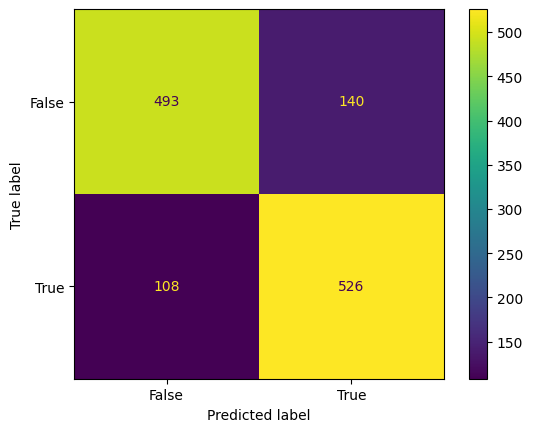

In [25]:
cm = metrics.confusion_matrix(Y_test, Y_test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])
cm_display.plot()
plt.show()

### 12. PASSIVE AGRESSIVE CLASSIFIER

### Model Training

In [26]:
classifier = PassiveAggressiveClassifier(max_iter=1000)
classifier.fit(tfidf_X_train,Y_train)


PassiveAggressiveClassifier()

### Prediction and Evaluation

In [27]:
Y_pred = classifier.predict(tfidf_X_test)
score = metrics.accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 93.13%


### Confusion Matrix

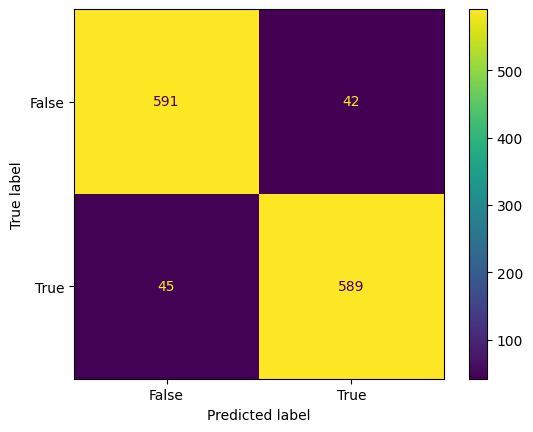

In [28]:
cm = metrics.confusion_matrix(Y_test, Y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])
cm_display.plot()
plt.show()

### 13. XGBoost

### Model training

In [29]:
xgb_model = XGBClassifier(
    learning_rate=0.001,         # Step size at each boosting iteration
    n_estimators=1000,           # Number of boosting rounds (trees)
    max_depth=10,                # Maximum depth of each decision tree
    min_child_weight=1,          # Minimum sum of instance weight needed in a child
    subsample=0.8,               # Fraction of samples used for fitting each tree
    colsample_bytree=0.8,        # Fraction of features used for fitting each tree
    objective='binary:logistic', # Objective function for binary classification
    seed=42,                     # Random seed for reproducibility
    gamma=0.01,                  # Minimum loss reduction required to make a further partition
    reg_lambda=0.1               # L2 regularization term on weights
)

xgb_model.fit(tfidf_X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.01, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Predition and Evaluation

In [30]:
# make predictions for test data
Y_pred_xgb = xgb_model.predict(tfidf_X_test)
predictions = [round(value) for value in Y_pred_xgb]
# evaluate predictions
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.06%


### Confusion Matrix

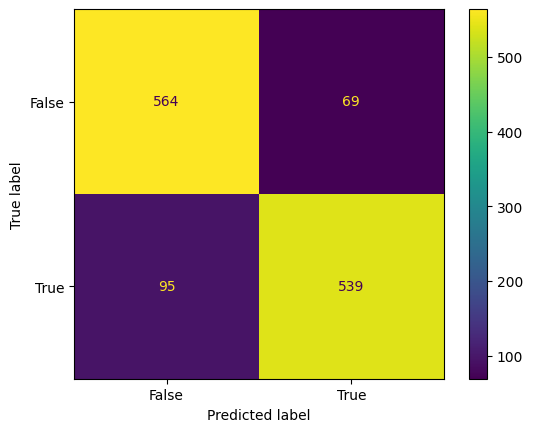

In [31]:
cm = metrics.confusion_matrix(Y_test, Y_pred_xgb)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])
cm_display.plot()
plt.show()


### 14. SUPPORT VECTOR MACHINES

### Model Training

In [32]:
# Create and train the SVM model
svm_model = SVC(kernel='linear', random_state=42)  # You can change the kernel ('linear', 'rbf', 'poly', etc.)
svm_model.fit(tfidf_X_train, Y_train)


SVC(kernel='linear', random_state=42)

### Prediction and Evaluation

In [35]:
# Predict testing data
Y_test_pred = svm_model.predict(tfidf_X_test)
# accuracy score of test data
accuracy = accuracy_score(Y_test_pred, Y_pred)
print("Accuracy: %.2f%%" % (test_accuracy * 100.0))

Accuracy: 80.43%


### Confusion Matrix

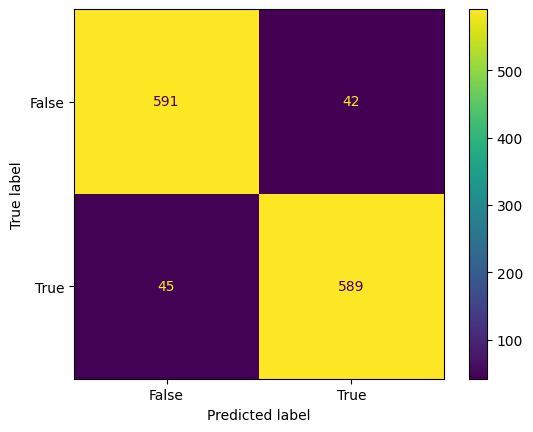

In [36]:
cm = metrics.confusion_matrix(Y_test, Y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])
cm_display.plot()
plt.show()

### 15. RANDOM FOREST CLASSIFIER

### Model Training

In [37]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # n_estimators is the number of trees in the forest
rf_model.fit(tfidf_X_train, Y_train)

RandomForestClassifier(random_state=42)

### Prediction and Evaluation

In [38]:
# Make predictions
y_pred = rf_model.predict(tfidf_X_train)
# Evaluate the model
test_accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy: %.2f%%" % (test_accuracy * 100.0))

Accuracy: 93.13%


### Confusion Matrix

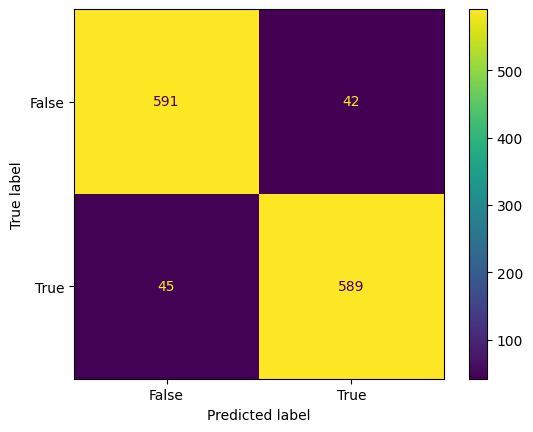

In [39]:
cm = metrics.confusion_matrix(Y_test, Y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])
cm_display.plot()
plt.show()

### 16. COMPARING MODELS



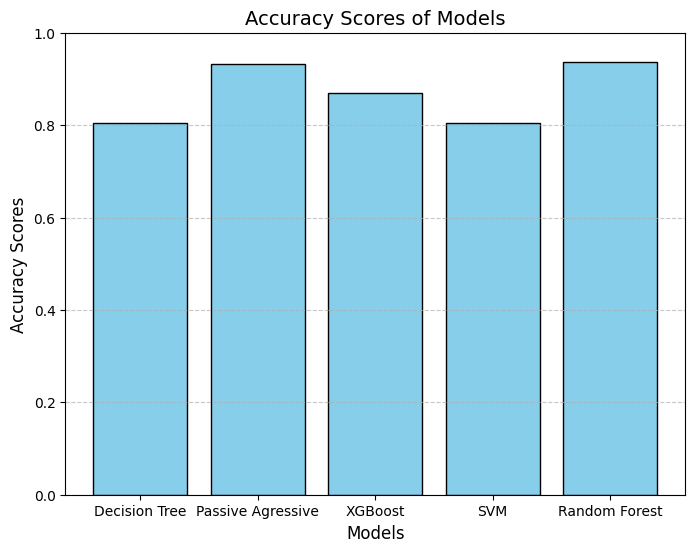

In [41]:
models = ['Decision Tree','Passive Agressive', 'XGBoost', 'SVM', 'Random Forest']
accuracy_scores = [0.8043, 0.9313, 0.8706, 0.8043, 0.9369]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracy_scores, color='skyblue', edgecolor='black')
plt.title('Accuracy Scores of Models', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy Scores', fontsize=12)
plt.ylim(0, 1)  # Set Y-axis limit from 0 to 1 (since accuracy is between 0 and 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 17. MAKING A PREDICTIVE SYSTEM

In [42]:
def fake_news_detector(news):
    input_data=[news]
    #vectorization
    vectorized_input_data=vectorizer.transform(input_data)
    #predicton
    prediction = classifier.predict(vectorized_input_data)
    # print(prediction)
    if(prediction[0]==0):
        print("Looks like a FAKE News")
    else:
        print("Looks like a REAL News")


### 18. RANDOM TESTING

In [43]:
fake_news_detector("Go to Article President Barack Obama has been campaigning hard for the woman who is supposedly going to extend his legacy four more years. The only problem with stumping for Hillary Clinton, however, is sheâ€™s not exactly a candidate easy to get too enthused about.  """)

Looks like a FAKE News


In [44]:
fake_news_detector('U.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this week, amid criticism that no top American officials attended Sundayâ€™s unity march against terrorism.')

Looks like a REAL News


In [45]:
fake_news_detector("Iranian negotiators reportedly have made a last-ditch push for more concessions from the U.S. and five other world powers as talks on the fate of Iran's nuclear program come down to the final days before a crucial deadline.The New York Times reported late Sunday that Tehran had backed away from a tentative promise to ship a large portion of its uranium stockpile to Russia, where it could not be used as part of any future weapons program. Western officials insisted to the paper that the uranium did not have to be sent overseas, but could be disposed of in other ways.The new twist in the talks comes just two days before the deadline for both sides to agree on a framework for a permanent deal. The final deadline for a permanent deal would not arrive until the end of June.However, if Iran insists on keeping its uranium in the country, it would undermine a key argument made in favor of the deal by the Obama administration. The Times reports that if the uranium had gone to Russia, it would have been converted into fuel rods, which are difficult to use in nuclear weapons. It is not clear what would happen to the uranium if it remained in Iran.The Associated Press reported Sunday that Iran's position had shifted from from demanding that it be allowed to keep nearly 10,000 centrifuges enriching uranium, to agreeing to keep 6,000. Western officials involved in the talks told the Associated Press that Tehran may be ready to accept an even lower number.The United States and its allies want a deal that extends the time Iran would need to make a nuclear weapon from the present two months to three months to at least a year. However, The Times reported Sunday that a paper published by Olli Heinonen, former head of inspections for the U.N.'s nuclear watchdog, estimated that Iran could still develop a nuclear weapon in seven or eight months with around 6,500 centrifuges.Tehran says it wants to enrich uranium only for energy, science, industry and medicine. But many countries fear Iran could use the technology to make weapons-grade uranium.Officials told the Associated Press that another main dispute involved the length of an agreement. Iran, they said, wants a total lifting of all caps on its activities after 10 years, while the U.S. and the five other nations at the talks â€” Russia, China, Britain, France and Germany â€” insist on progressive removal after a decade.A senior U.S. official characterized the issue as lack of agreement on what happens in years 11 to 15. The official spoke on condition of anonymity in line with State Department rules on briefing about the closed-door talks.Limits on Iran's research and development of centrifuges also were unresolved, the Western officials said.Tehran has created a prototype centrifuge that it says enriches uranium 16 times faster than its present mainstay model. The U.S. and its partners want to constrain research that would increase greatly the speed of making enough weapons-grade uranium for a bomb, once limits on Iran's programs are lifted.One official said Russia opposed the U.S. position that any U.N. penalties lifted in the course of a deal should be reimposed quickly if Tehran reneged on any commitments.Both Western officials said Iran was resisting attempts to make inspections and other ways of verification as intrusive as possible.There was tentative agreement on turning a nearly-finished reactor into a model that gives off less plutonium waste than originally envisaged. Plutonium, like enriched uranium, is a path to nuclear weapons.Iran and the U.S. were discussing letting Iran run centrifuges at an underground bunker that has been used to enrich uranium. The machines would produce isotopes for peaceful applications, the officials said.With the Tuesday deadline approaching and problems remaining, U.S. Secretary of State John Kerry canceled plans Sunday to return to the United States for an event honoring the late U.S. Sen. Edward Kennedy. French Foreign Minister Laurent Fabius and Frank-Walter Steinmeier, his German counterpart, scratched planned trips to Kazakhstan.Kerry has been in discussions with Iranian Foreign Minister Mohammad Javad Zarif since Thursday.The Associated Press contributed to this report.Click for more from The New York Times.")

Looks like a REAL News


In [46]:
fake_news_detector("After a week of nonstop criticism from Democrats and Republicans alike for comments many condemned as racially charged, Donald Trump claims to be altering his campaign to be a little more inclusive. While the presumptive G.O.P. has long promised to â€œmake America great again,â€ Trump now says heâ€™s adding two words to slogan to illustrate just how non-racist he really is.â€œYou know, I have the theme â€˜make America great again,â€™ and I've added a couple of things,â€ Trump announced to supporters at a campaign rally in Richmond, Virginia, on Friday night. â€œRight now Iâ€™m adding make America great againâ€”Iâ€™m adding â€˜for everyone,â€™ because itâ€™s really going to be for everyone. Itâ€™s not going to be for a group of people, itâ€™s going to be for everyone. Itâ€™s true.â€The allegedly amended slogan, which has yet to appear on any official signage or Trump merchandise, comes after the presidential candidate spent the first half of June repeatedly denouncing Gonzalo Curiel, the federal judge of Mexican heritage presiding over the Trump University class action lawsuit, as inherently biased against him. (Curiel was born in Indiana.) His comments were widely condemned by the Washington political establishment, including Senate Minority Leader Mitch McConnell, who suggested he may be an idiot, and House Speaker Paul Ryan, who called Trumpâ€™s statement the â€œtextbook definition of a racist comment.â€Trump, who hasnâ€™t apologized or taken back any of his comments, indicated on Friday that he realized his words have had a negative effect on his campaign and declared he is not a racist.â€œI am the least racist person. The least racist person that youâ€™ve ever seen. I mean give me a break,â€ he said at the rally. â€œI am the least racist person that youâ€™ve ever looked at, believe me.â€")

Looks like a REAL News


### 19. SAVING THE MODEL

In [47]:
pickle.dump(classifier, open('models/model.pkl', 'wb'))
pickle.dump(vectorizer, open('models/tfidfvect.pkl', 'wb'))

### 20. LOADING THE MODEL AND CHECKING WITHOUT TRAINING

In [48]:
model = pickle.load(open('models/model.pkl', 'rb'))
vect = pickle.load(open('models/tfidfvect.pkl', 'rb'))

In [49]:
# Load model and vectorizer
news = "After a week of nonstop criticism from Democrats and Republicans alike for comments many condemned as racially charged, Donald Trump claims to be altering his campaign to be a little more inclusive. While the presumptive G.O.P. has long promised to â€œmake America great again,â€ Trump now says heâ€™s adding two words to slogan to illustrate just how non-racist he really is.â€œYou know, I have the theme â€˜make America great again,â€™ and I've added a couple of things,â€ Trump announced to supporters at a campaign rally in Richmond, Virginia, on Friday night. â€œRight now Iâ€™m adding make America great againâ€”Iâ€™m adding â€˜for everyone,â€™ because itâ€™s really going to be for everyone. Itâ€™s not going to be for a group of people, itâ€™s going to be for everyone. Itâ€™s true.â€The allegedly amended slogan, which has yet to appear on any official signage or Trump merchandise, comes after the presidential candidate spent the first half of June repeatedly denouncing Gonzalo Curiel, the federal judge of Mexican heritage presiding over the Trump University class action lawsuit, as inherently biased against him. (Curiel was born in Indiana.) His comments were widely condemned by the Washington political establishment, including Senate Minority Leader Mitch McConnell, who suggested he may be an idiot, and House Speaker Paul Ryan, who called Trumpâ€™s statement the â€œtextbook definition of a racist comment.â€Trump, who hasnâ€™t apologized or taken back any of his comments, indicated on Friday that he realized his words have had a negative effect on his campaign and declared he is not a racist.â€œI am the least racist person. The least racist person that youâ€™ve ever seen. I mean give me a break,â€ he said at the rally. â€œI am the least racist person that youâ€™ve ever looked at, believe me.â€"

val_pkl = vect.transform([news]).toarray()
pred_pkl=model.predict(val_pkl)
if(pred_pkl[0]==0):
        print("Looks like a FAKE News")
else:
        print("Looks like a REAL News")

Looks like a REAL News


In [50]:
news="Iranian negotiators reportedly have made a last-ditch push for more concessions from the U.S. and five other world powers as talks on the fate of Iran's nuclear program come down to the final days before a crucial deadline.The New York Times reported late Sunday that Tehran had backed away from a tentative promise to ship a large portion of its uranium stockpile to Russia, where it could not be used as part of any future weapons program. Western officials insisted to the paper that the uranium did not have to be sent overseas, but could be disposed of in other ways.The new twist in the talks comes just two days before the deadline for both sides to agree on a framework for a permanent deal. The final deadline for a permanent deal would not arrive until the end of June.However, if Iran insists on keeping its uranium in the country, it would undermine a key argument made in favor of the deal by the Obama administration. The Times reports that if the uranium had gone to Russia, it would have been converted into fuel rods, which are difficult to use in nuclear weapons. It is not clear what would happen to the uranium if it remained in Iran.The Associated Press reported Sunday that Iran's position had shifted from from demanding that it be allowed to keep nearly 10,000 centrifuges enriching uranium, to agreeing to keep 6,000. Western officials involved in the talks told the Associated Press that Tehran may be ready to accept an even lower number.The United States and its allies want a deal that extends the time Iran would need to make a nuclear weapon from the present two months to three months to at least a year. However, The Times reported Sunday that a paper published by Olli Heinonen, former head of inspections for the U.N.'s nuclear watchdog, estimated that Iran could still develop a nuclear weapon in seven or eight months with around 6,500 centrifuges.Tehran says it wants to enrich uranium only for energy, science, industry and medicine. But many countries fear Iran could use the technology to make weapons-grade uranium.Officials told the Associated Press that another main dispute involved the length of an agreement. Iran, they said, wants a total lifting of all caps on its activities after 10 years, while the U.S. and the five other nations at the talks â€” Russia, China, Britain, France and Germany â€” insist on progressive removal after a decade.A senior U.S. official characterized the issue as lack of agreement on what happens in years 11 to 15. The official spoke on condition of anonymity in line with State Department rules on briefing about the closed-door talks.Limits on Iran's research and development of centrifuges also were unresolved, the Western officials said.Tehran has created a prototype centrifuge that it says enriches uranium 16 times faster than its present mainstay model. The U.S. and its partners want to constrain research that would increase greatly the speed of making enough weapons-grade uranium for a bomb, once limits on Iran's programs are lifted.One official said Russia opposed the U.S. position that any U.N. penalties lifted in the course of a deal should be reimposed quickly if Tehran reneged on any commitments.Both Western officials said Iran was resisting attempts to make inspections and other ways of verification as intrusive as possible.There was tentative agreement on turning a nearly-finished reactor into a model that gives off less plutonium waste than originally envisaged. Plutonium, like enriched uranium, is a path to nuclear weapons.Iran and the U.S. were discussing letting Iran run centrifuges at an underground bunker that has been used to enrich uranium. The machines would produce isotopes for peaceful applications, the officials said.With the Tuesday deadline approaching and problems remaining, U.S. Secretary of State John Kerry canceled plans Sunday to return to the United States for an event honoring the late U.S. Sen. Edward Kennedy. French Foreign Minister Laurent Fabius and Frank-Walter Steinmeier, his German counterpart, scratched planned trips to Kazakhstan.Kerry has been in discussions with Iranian Foreign Minister Mohammad Javad Zarif since Thursday.The Associated Press contributed to this report.Click for more from The New York Times."
val_pkl = vect.transform([news]).toarray()
pred_pkl=model.predict(val_pkl)
if(pred_pkl[0]==0):
        print("Looks like a FAKE News")
else:
        print("Looks like a REAL News")

Looks like a REAL News


In [51]:
news="President Obama's supporters sometimes wonder where the inspirational candidate of 2008 has gone. The answer is to the White House. Obama's presidency is about smaller, less inspiring questions than his 2008 campaigObama's presidency is bounded by the limits of the office and the demands of the moment. It is about what America needs to do right now â€” the next budget, the next bill, next year's taxes, the last war. Candidates can muse. Presidents must goverObama's 2008 campaign was about what kind of country America is; how to read its past to best guide its future. His speech in Selma â€” which is reallyÂ worth reading in its entirety â€” was among the best of his presidency precisely because it had almost nothing to do with his presidency; it was a return to the central topic of his campaigHistorians who want to understand Obama will find few better summations than the two paragraphs at the core of this speecWe do a disservice to the cause of justice by intimating that bias and discrimination are immutable, or that racial division is inherent to America. If you think nothing's changed in the past fifty years, ask somebody who lived through the Selma or Chicago or L.A. of the Fifties. Ask the female CEO who once might have been assigned to the secretarial pool if nothing's changed. Ask your gay friend if it's easier to be out and proud in America now than it was thirty years ago. To deny this progress â€” our progress â€” would be to rob us of our own agency; our responsibility to do what we can to make America better. Of course, a more common mistake is to suggest that racism is banished, that the work that drew men and women to Selma is complete, and that whatever racial tensions remain are a consequence of those seeking to play the 'race card' for their own purposes. We don't need the Ferguson report to know that's not true. We just need to open our eyes, and ears, and hearts, to know that this nation's racial history still casts its long shadow upon us. We know the march is not yet over, the race is not yet won, and that reaching that blessed destination where we are judged by the content of our character requires admitting as mucThose 230 words are a precise distillation of Obama's view of America, and the role politics must play in it.The first paragraph is Obama's case for hope: America is improving; it has always been improving, and to deny that improvement is to steal from Americans a belief in their country that they have more than earned. 'To deny this progress â€' our progress â€' would be to rob us of our own agency,'he said.The second paragraph is Obama's case for change: America's sins are not vanquished; its hatreds remain real; its racism still breathes. 'We know the march is not yet over,' Obama said, 'the race is not yet won, and that reaching that blessed destination where we are judged by the content of our character requires admitting as much.'Hope and change. These are the two ideas that form the steady core of Obama's politics. But, more than that, they are the two ideas that define, for Obama, what kind of country America is â€” and what it means to serve it.Obama's critics question his love for the country he governs. 'I do not believe â€' and I know this is a horrible thing to say â€' but I do not believe that the president loves America,' former New York Mayor Rudy Giuliani said in February. They look at Obama's steady belief that America is not yet good enough, not yet pure enough, not yet perfect enough, and they see a skeptic, not a patriot.In this speech, Obama's answer to this criticism was direct:Fellow marchers, so much has changed in fifty years. We've endured war, and fashioned peace. We've seen technological wonders that touch every aspect of our lives, and take for granted convenience our parents might scarcely imagine. But what has not changed is the imperative of citizenship, that willingness of a 26 year-old deacon, or a Unitarian minister, or a young mother of five, to decide they loved this country so much that they'd risk everything to realize its promise. That's what it means to love America. That's what it means to believe in America. That's what it means when we say America is exceptional.There is an implicit radicalism in what Obama is saying here.Â To believe America is good enough is to abandon the tradition of criticism and activism that has made America great.Obama's answer to Giuliani is that Giuliani has mistaken uncritical adoration for the hard work required of true love. Patriotism is active, not passive. Those who love America prove it by working to perfect America. They continue marching."
val_pkl = vect.transform([news]).toarray()
pred_pkl=model.predict(val_pkl)
if(pred_pkl[0]==0):
        print("Looks like a FAKE News")
else:
        print("Looks like a REAL News")

Looks like a REAL News


### The Model is Working Perfect, now will Deploy the mode


the end of this file!!!!!!